# Structuring Unstructured Digitized Data

Problem: You would like to make a character network map from Shakespeare's *Hamlet*, similar to what Moretti does in his work. All you have is a raw text file of *Hamlet* that you have copy-and-pasted from Project Gutenberg. How do you go from raw text, to network map?

Solution: flex your Python muscles and bring together everything you know to structure the raw text (plus a new library, Networkx!).

Outcome: combine the tools we already know, string methods, list methods, regular expressions, and Pandas, plus add a new library to our toolkit, to create a very rough character network map of Shakespeare's *Hamlet*.

The interesting substantive question is [what constitutes a link between characters in a play](http://digitalhumanities.org/dhq/vol/11/2/000289/000289.html).

We will construct our (imperfect) network via the following method (from the linked article above):


>The network structure calculations were obtained by treating each speaking character as a node, and deeming two characters to be linked if there was at least one time slice of the play in which both were present (that is, if two characters spoke to each other or were in each other’s presence, then they have a link).  [[Stiller, Nettle, and Dunbar 2003, 399](https://link.springer.com/article/10.1007/s12110-003-1013-1)]

**This is not an active learning tutorial (sorry!).** Rather, it's a demonstration of my workflow as I face a new set of unstructured data, and an end goal of how I want it structured. 

## Learning Goals

* Think through how you can combine tools you already know to extract and structure the information you want from a raw, semi-structured text file.
    * Note the vast number of tools we use to do this relatively simple example. Getting comfortable with these basic tools is really important to do more sophisticated work! Practice, practice, practice.
* Review of all the tools we have learned and how they work together to form one, powerful ecosystem.
* Learn the basics of creating an adjacency matrix, and turning that matrix into a network graph using the Python library Networkx.
    * **Carefull!!** You now know just enough to be dangerous. **Proceed with caution.** If you think network analysis might be something you want to do in your own resesarch **go take a class in it**. Lots of resources here to do excellent network analysis projects.
* Through this exercise, you should note how much cleaning happens, how many mistakes get through despite our best efforts, and how many decisions I as a researcher have to make. 
    * Note the importance of making explicit every decision you make. **Most authors unfortunately do not do this**. I hope with your generation we can change that.
    * Y'all, this is real. This is how research is being done right now.
* Learn strategies for breaking down a complicated task into smaller parts.
    * Proceed one step at a time, and print everything you do to check you're doing it correctly.
    * Note also the different types of computational essays you might create. You might create one that simply structures your data, and another to do the analyses, for example.

### OK, get ready!!!

In [12]:
#import our libraries
import pandas
import re
import networkx as nx
import numpy as np #needed to create a matrix for our network graph
import matplotlib.pyplot as plt

In [1]:
#read in our text file
hamlet = open('../data/hamlet.txt', 'r').read()
hamlet[:1000]

'\nProject Gutenberg EBook of Hamlet, by William Shakespeare\n\nThis eBook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no\nrestrictions whatsoever.  You may copy it, give it away or re-use it\nunder the terms of the Project Gutenberg License included with this\neBook or online at www.gutenberg.org.  If you are not located in the\nUnited States, you’ll have to check the laws of the country where you\nare located before using this ebook.\n\n\n\nTitle: Hamlet\n\nAuthor: William Shakespeare\n\nRelease Date: November 1998 [EBook #1524]\n\nLast Updated: December 30, 2017\n\nLanguage: English\n\nCharacter set encoding: UTF-8\n\n*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***\n\n\n\nThis etext was prepared by Dianne Bean.\n\n\nTHE TRAGEDY OF HAMLET, PRINCE OF DENMARK\n\n\n\n\nby William Shakespeare\n\n\n\n\n\n\nContents\n\nACT I Scene I. Elsinore. A platform before the Castle. Scene II.\nElsinore. A room of state in 

Our first goal is to identify which characters were in each other's presence at any time throughout the play. We will approximate this by counting a positive tie if two characters had speaking lines in the same scene.

The text is semi-structured via ACTs and SCENEs. We'll use this semi-structure to explit the full file into acts, and then scenes within each act, with the goal of creating a list of characters present in each scene.

First, use the string `.find` method to locate the ACTs:

In [2]:
hamlet.find("ACT I\n")

2346

In [3]:
hamlet.find("ACT II\n")

41315

In [4]:
hamlet.find("ACT III\n")

74231

In [5]:
hamlet.find("ACT IV\n")

115951

In [6]:
hamlet.find("ACT V\n")

145886

In [7]:
hamlet.find("ACT VI\n")

-1

In [8]:
actI = hamlet[hamlet.find("ACT I\n") : hamlet.find("ACT II\n")]
actI

'ACT I\n\nSCENE I. Elsinore. A platform before the Castle.\n\n Enter Francisco and Barnardo, two sentinels.\n\nBARNARDO. Who’s there?\n\nFRANCISCO. Nay, answer me. Stand and unfold yourself.\n\nBARNARDO. Long live the King!\n\nFRANCISCO. Barnardo?\n\nBARNARDO. He.\n\nFRANCISCO. You come most carefully upon your hour.\n\nBARNARDO. ’Tis now struck twelve. Get thee to bed, Francisco.\n\nFRANCISCO. For this relief much thanks. ’Tis bitter cold, And I am sick\nat heart.\n\nBARNARDO. Have you had quiet guard?\n\nFRANCISCO. Not a mouse stirring.\n\nBARNARDO. Well, good night. If you do meet Horatio and Marcellus, The\nrivals of my watch, bid them make haste.\n\n Enter Horatio and Marcellus.\n\nFRANCISCO. I think I hear them. Stand, ho! Who is there?\n\nHORATIO. Friends to this ground.\n\nMARCELLUS. And liegemen to the Dane.\n\nFRANCISCO. Give you good night.\n\nMARCELLUS. O, farewell, honest soldier, who hath reliev’d you?\n\nFRANCISCO. Barnardo has my place. Give you good-night.\n\n [_Exit._

In [9]:
actII = hamlet[hamlet.find("ACT II\n") : hamlet.find("ACT III\n")]
actII

'ACT II\n\nSCENE I. A room in Polonius’s house.\n\n Enter Polonius and Reynaldo.\n\nPOLONIUS. Give him this money and these notes, Reynaldo.\n\nREYNALDO. I will, my lord.\n\nPOLONIUS. You shall do marvellous wisely, good Reynaldo, Before you\nvisit him, to make inquiry Of his behaviour.\n\nREYNALDO. My lord, I did intend it.\n\nPOLONIUS. Marry, well said; very well said. Look you, sir, Enquire me\nfirst what Danskers are in Paris; And how, and who, what means, and\nwhere they keep, What company, at what expense; and finding By this\nencompassment and drift of question, That they do know my son, come you\nmore nearer Than your particular demands will touch it. Take you as\n’twere some distant knowledge of him, As thus, ‘I know his father and\nhis friends, And in part him’—do you mark this, Reynaldo?\n\nREYNALDO. Ay, very well, my lord.\n\nPOLONIUS. ‘And in part him, but,’ you may say, ‘not well; But if’t be\nhe I mean, he’s very wild; Addicted so and so;’ and there put on him\nWhat forg

And so on. Do the next three acts.

In [10]:
actIII = hamlet[hamlet.find("ACT III\n") : hamlet.find("ACT IV\n")]
actIV = hamlet[hamlet.find("ACT IV\n") : hamlet.find("ACT V\n")]
actV = hamlet[hamlet.find("ACT V\n") : hamlet.find("End of the Project Gutenberg EBook")]

Next, split each ACT by SCENE, using regular expressions:

In [13]:
actI_scenes = re.findall("SCENE [A-Z]+", actI)
actI_scenes

['SCENE I', 'SCENE II', 'SCENE III', 'SCENE IV', 'SCENE V']

In [14]:
#Write a for loop to split each act into scenes
for idx,scene in enumerate(actI_scenes):
    print(idx, scene)

0 SCENE I
1 SCENE II
2 SCENE III
3 SCENE IV
4 SCENE V


In [15]:
actI_scenes.append("End of the Project Gutenberg EBook")
actI_scenes

['SCENE I',
 'SCENE II',
 'SCENE III',
 'SCENE IV',
 'SCENE V',
 'End of the Project Gutenberg EBook']

In [16]:
#Write a for loop to split each act into scenes
actI_list = list()
for idx,scene in enumerate(actI_scenes):
    if idx <= (len(actI_scenes)-2):
        scene_text = actI[actI.find(actI_scenes[idx]): actI.find(actI_scenes[idx+1])]
        actI_list.append(tuple((("act1_scene"+str(idx+1)),scene_text)))
actI_list

[('act1_scene1',
  'SCENE I. Elsinore. A platform before the Castle.\n\n Enter Francisco and Barnardo, two sentinels.\n\nBARNARDO. Who’s there?\n\nFRANCISCO. Nay, answer me. Stand and unfold yourself.\n\nBARNARDO. Long live the King!\n\nFRANCISCO. Barnardo?\n\nBARNARDO. He.\n\nFRANCISCO. You come most carefully upon your hour.\n\nBARNARDO. ’Tis now struck twelve. Get thee to bed, Francisco.\n\nFRANCISCO. For this relief much thanks. ’Tis bitter cold, And I am sick\nat heart.\n\nBARNARDO. Have you had quiet guard?\n\nFRANCISCO. Not a mouse stirring.\n\nBARNARDO. Well, good night. If you do meet Horatio and Marcellus, The\nrivals of my watch, bid them make haste.\n\n Enter Horatio and Marcellus.\n\nFRANCISCO. I think I hear them. Stand, ho! Who is there?\n\nHORATIO. Friends to this ground.\n\nMARCELLUS. And liegemen to the Dane.\n\nFRANCISCO. Give you good night.\n\nMARCELLUS. O, farewell, honest soldier, who hath reliev’d you?\n\nFRANCISCO. Barnardo has my place. Give you good-night.\n\

Next, identify the characters in each scene. We'll do this first with ACT I, SCENE 2, and then put it together and do all scenes

In [17]:
act1_scene2 = actI_list[1][1]
act1_scene2

'SCENE II. Elsinore. A room of state in the Castle.\n\n Enter Claudius King of Denmark, Gertrude the Queen, Hamlet, Polonius,\n Laertes, Voltemand, Cornelius, Lords and Attendant.\n\nKING. Though yet of Hamlet our dear brother’s death The memory be\ngreen, and that it us befitted To bear our hearts in grief, and our\nwhole kingdom To be contracted in one brow of woe; Yet so far hath\ndiscretion fought with nature That we with wisest sorrow think on him,\nTogether with remembrance of ourselves. Therefore our sometime sister,\nnow our queen, Th’imperial jointress to this warlike state, Have we, as\n’twere with a defeated joy, With one auspicious and one dropping eye,\nWith mirth in funeral, and with dirge in marriage, In equal scale\nweighing delight and dole, Taken to wife; nor have we herein barr’d\nYour better wisdoms, which have freely gone With this affair along. For\nall, our thanks. Now follows, that you know young Fortinbras, Holding a\nweak supposal of our worth, Or thinking by 

In [18]:
#use regular expressions to find all the characters in a scene
re.findall('\n\n([\w ]+)\.', act1_scene2)

['KING',
 'CORNELIUS and VOLTEMAND',
 'KING',
 'LAERTES',
 'KING',
 'POLONIUS',
 'KING',
 'HAMLET',
 'KING',
 'HAMLET',
 'QUEEN',
 'HAMLET',
 'QUEEN',
 'HAMLET',
 'KING',
 'QUEEN',
 'HAMLET',
 'KING',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'MARCELLUS',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'MARCELLUS',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'Mar',
 'HAMLET',
 'Both',
 'HAMLET',
 'BOTH',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'MARCELLUS and BARNARDO',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'HORATIO',
 'HAMLET',
 'ALL',
 'HAMLET']

In [19]:
#pull out the unique characters (we're ignoring number of lines spoken for now)
act1scene2_charaters = list(set(re.findall('\n\n([\w ]+)\.', act1_scene2)))
act1scene2_charaters

['HAMLET',
 'QUEEN',
 'KING',
 'Both',
 'ALL',
 'BOTH',
 'Mar',
 'LAERTES',
 'HORATIO',
 'MARCELLUS and BARNARDO',
 'CORNELIUS and VOLTEMAND',
 'POLONIUS',
 'MARCELLUS']

In [20]:
##Oops! There are some problems. Two characters listed in the same element, for example.
##Loop through and separate those elements
new_char_list = list()
for char in act1scene2_charaters:
    if 'Enter' in char:
        pass
    elif 'and' in char:
        new_char = char.split(' and ')
        print(new_char)

['MARCELLUS', 'BARNARDO']
['CORNELIUS', 'VOLTEMAND']


In [21]:
new_char_list = list()
for char in act1scene2_charaters:
    if 'Enter' in char:
        pass
    elif 'and' in char:
        new_char = char.split(' and ')
        new_char_list.extend([new_char[0], new_char[1]])
    else:
        new_char_list.append(char)
new_char_list

['HAMLET',
 'QUEEN',
 'KING',
 'Both',
 'ALL',
 'BOTH',
 'Mar',
 'LAERTES',
 'HORATIO',
 'MARCELLUS',
 'BARNARDO',
 'CORNELIUS',
 'VOLTEMAND',
 'POLONIUS',
 'MARCELLUS']

In [22]:
#Put it all together with multiple for-loops and nested if/else statements
#create a master list of tuples, where the first element is the act/scene number
#the second element a list of unique characters that appear in that scene

acts = [actI, actII, actIII, actIV, actV]
scene_list = list()
for actidx, act in enumerate(acts):
    act_scenes = re.findall("SCENE [A-Z]+", act)
    act_scenes.append("End of the Project Gutenberg EBook")
    act_list = list()
    for idx,scene in enumerate(act_scenes):
        if idx <= (len(act_scenes)-2):
            scene_text = act[act.find(act_scenes[idx]): act.find(act_scenes[idx+1])]
            act_list.append(tuple((("act"+str(actidx+1)+"_scene"+str(idx+1)),scene_text)))
    act_list_char = list()
    for scene, text in act_list:
        act_list_char.append(tuple((scene,list(set(re.findall('\n\n([\w ]+)\.', text))) )))
    for scene,character in act_list_char:
        new_char_list = list()
        for char in character:
            if 'Enter' in char:
                pass
            elif 'and' in char:
                new_char = char.split(' and ')
                new_char_list.extend([new_char[0], new_char[1]])
            else:
                new_char_list.append(char)
        scene_list.append(tuple((scene,new_char_list)))
scene_list

[('act1_scene1',
  ['BARNARDO It would be spoke to',
   'HORATIO',
   'FRANCISCO',
   'BARNARDO',
   'MARCELLUS']),
 ('act1_scene2',
  ['HAMLET',
   'QUEEN',
   'KING',
   'Both',
   'ALL',
   'BOTH',
   'Mar',
   'LAERTES',
   'HORATIO',
   'MARCELLUS',
   'BARNARDO',
   'CORNELIUS',
   'VOLTEMAND',
   'POLONIUS',
   'MARCELLUS']),
 ('act1_scene3',
  ['And these few precepts in thy memory Look thou character',
   'OPHELIA',
   'LAERTES',
   'POLONIUS']),
 ('act1_scene4', ['HAMLET', 'HORATIO', 'MARCELLUS']),
 ('act1_scene5',
  ['HAMLET', 'GHOST', 'HORATIO', 'MARCELLUS', 'HORATIO', 'MARCELLUS']),
 ('act2_scene1', ['REYNALDO', 'OPHELIA', 'POLONIUS']),
 ('act2_scene2',
  ['HAMLET',
   'QUEEN',
   'KING',
   'GUILDENSTERN',
   'ROSENCRANTZ',
   'GUILDENSTERN',
   'ROSENCRANTZ',
   'FIRST PLAYER',
   'VOLTEMAND',
   'POLONIUS']),
 ('act3_scene1',
  ['HAMLET',
   'QUEEN',
   'KING',
   'GUILDENSTERN',
   'ROSENCRANTZ',
   'OPHELIA',
   'POLONIUS']),
 ('act3_scene2',
  ['PLAYER KING',
   'ROS

# Part II: Network Graph

Great! We've put some useful structure to our unstructured text.

Next steps:

1. Create an adjency matrix, counting the number of scenes each pair of characters appear together
2. Turn the adjency matrix into a network object, to graph it and calculate network statistics

In [23]:
#create a list of all unique characters in the play. This will be our rows and columns
all_characters = list()
for key, value in scene_list:
    print(value)

['BARNARDO It would be spoke to', 'HORATIO', 'FRANCISCO', 'BARNARDO', 'MARCELLUS']
['HAMLET', 'QUEEN', 'KING', 'Both', 'ALL', 'BOTH', 'Mar', 'LAERTES', 'HORATIO', 'MARCELLUS', 'BARNARDO', 'CORNELIUS', 'VOLTEMAND', 'POLONIUS', 'MARCELLUS']
['And these few precepts in thy memory Look thou character', 'OPHELIA', 'LAERTES', 'POLONIUS']
['HAMLET', 'HORATIO', 'MARCELLUS']
['HAMLET', 'GHOST', 'HORATIO', 'MARCELLUS', 'HORATIO', 'MARCELLUS']
['REYNALDO', 'OPHELIA', 'POLONIUS']
['HAMLET', 'QUEEN', 'KING', 'GUILDENSTERN', 'ROSENCRANTZ', 'GUILDENSTERN', 'ROSENCRANTZ', 'FIRST PLAYER', 'VOLTEMAND', 'POLONIUS']
['HAMLET', 'QUEEN', 'KING', 'GUILDENSTERN', 'ROSENCRANTZ', 'OPHELIA', 'POLONIUS']
['PLAYER KING', 'ROSENCRANTZ', 'FIRST PLAYER', 'OPHELIA', 'QUEEN', ' Danish march', ' Trumpets sound', 'PROLOGUE', 'KING', 'GUILDENSTERN', 'PLAYER QUEEN', 'LUCIANUS', 'HAMLET', 'ROSENCRANTZ', 'GUILDENSTERN', 'HORATIO', 'POLONIUS', 'All']
['HAMLET', 'KING', ' The King rises', 'advances', 'GUILDENSTERN', 'ROSENCRAN

In [24]:
all_characters = list()
for key, value in scene_list:
    all_characters.extend(value)
all_characters

['BARNARDO It would be spoke to',
 'HORATIO',
 'FRANCISCO',
 'BARNARDO',
 'MARCELLUS',
 'HAMLET',
 'QUEEN',
 'KING',
 'Both',
 'ALL',
 'BOTH',
 'Mar',
 'LAERTES',
 'HORATIO',
 'MARCELLUS',
 'BARNARDO',
 'CORNELIUS',
 'VOLTEMAND',
 'POLONIUS',
 'MARCELLUS',
 'And these few precepts in thy memory Look thou character',
 'OPHELIA',
 'LAERTES',
 'POLONIUS',
 'HAMLET',
 'HORATIO',
 'MARCELLUS',
 'HAMLET',
 'GHOST',
 'HORATIO',
 'MARCELLUS',
 'HORATIO',
 'MARCELLUS',
 'REYNALDO',
 'OPHELIA',
 'POLONIUS',
 'HAMLET',
 'QUEEN',
 'KING',
 'GUILDENSTERN',
 'ROSENCRANTZ',
 'GUILDENSTERN',
 'ROSENCRANTZ',
 'FIRST PLAYER',
 'VOLTEMAND',
 'POLONIUS',
 'HAMLET',
 'QUEEN',
 'KING',
 'GUILDENSTERN',
 'ROSENCRANTZ',
 'OPHELIA',
 'POLONIUS',
 'PLAYER KING',
 'ROSENCRANTZ',
 'FIRST PLAYER',
 'OPHELIA',
 'QUEEN',
 ' Danish march',
 ' Trumpets sound',
 'PROLOGUE',
 'KING',
 'GUILDENSTERN',
 'PLAYER QUEEN',
 'LUCIANUS',
 'HAMLET',
 'ROSENCRANTZ',
 'GUILDENSTERN',
 'HORATIO',
 'POLONIUS',
 'All',
 'HAMLET',
 'K

In [25]:
unique_characters = list(set(all_characters))
unique_characters

['BARNARDO It would be spoke to',
 'ALL',
 'CORNELIUS',
 'PLAYER KING',
 ' The King rises',
 'SERVANT',
 'SECOND CLOWN',
 'CAPTAIN',
 'ROSENCRANTZ',
 'LAERTES',
 'OPHELIA',
 'FIRST PLAYER',
 'OSRIC',
 'BARNARDO',
 'Come',
 'QUEEN',
 'Both',
 ' Danish march',
 ' Trumpets sound',
 'advances',
 'Danes',
 'PROLOGUE',
 'VOLTEMAND',
 'Give him the cup',
 'KING',
 'GHOST',
 'GUILDENSTERN',
 'MESSENGER',
 'REYNALDO',
 'BOTH',
 'PLAYER QUEEN',
 'FORTINBRAS',
 'LUCIANUS',
 'PRIEST',
 'Mar',
 'MARCELLUS',
 'And these few precepts in thy memory Look thou character',
 'FIRST AMBASSADOR',
 'HAMLET',
 'GENTLEMAN',
 'FIRST SAILOR',
 'FIRST CLOWN',
 'LORDS',
 'HORATIO',
 'FRANCISCO',
 'POLONIUS',
 'DANES',
 'LORD',
 'All']

In [26]:
#Roughly clean up some of the errors
unique_characters = [char for char in unique_characters if char.isupper()]
unique_characters

['ALL',
 'CORNELIUS',
 'PLAYER KING',
 'SERVANT',
 'SECOND CLOWN',
 'CAPTAIN',
 'ROSENCRANTZ',
 'LAERTES',
 'OPHELIA',
 'FIRST PLAYER',
 'OSRIC',
 'BARNARDO',
 'QUEEN',
 'PROLOGUE',
 'VOLTEMAND',
 'KING',
 'GHOST',
 'GUILDENSTERN',
 'MESSENGER',
 'REYNALDO',
 'BOTH',
 'PLAYER QUEEN',
 'FORTINBRAS',
 'LUCIANUS',
 'PRIEST',
 'MARCELLUS',
 'FIRST AMBASSADOR',
 'HAMLET',
 'GENTLEMAN',
 'FIRST SAILOR',
 'FIRST CLOWN',
 'LORDS',
 'HORATIO',
 'FRANCISCO',
 'POLONIUS',
 'DANES',
 'LORD']

In [27]:
len(unique_characters)

37

In [28]:
#create a zero square dataframe with characters as columns and rows
df = pandas.DataFrame(0, columns=unique_characters, index=unique_characters)
df

,ALL,CORNELIUS,PLAYER KING,SERVANT,SECOND CLOWN,CAPTAIN,ROSENCRANTZ,LAERTES,OPHELIA,FIRST PLAYER,...,HAMLET,GENTLEMAN,FIRST SAILOR,FIRST CLOWN,LORDS,HORATIO,FRANCISCO,POLONIUS,DANES,LORD
ALL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CORNELIUS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PLAYER KING,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SERVANT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SECOND CLOWN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CAPTAIN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ROSENCRANTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LAERTES,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OPHELIA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FIRST PLAYER,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#reminder: how do we change values in a dataframe?
df_example = df.copy()
df_example.loc['BARNARDO']['QUEEN'] += 1
df_example

,ALL,CORNELIUS,PLAYER KING,SERVANT,SECOND CLOWN,CAPTAIN,ROSENCRANTZ,LAERTES,OPHELIA,FIRST PLAYER,...,HAMLET,GENTLEMAN,FIRST SAILOR,FIRST CLOWN,LORDS,HORATIO,FRANCISCO,POLONIUS,DANES,LORD
ALL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CORNELIUS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PLAYER KING,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SERVANT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SECOND CLOWN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CAPTAIN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ROSENCRANTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LAERTES,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OPHELIA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FIRST PLAYER,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#set up a for loop to loop through the characters in the index
for char in df.index:
    print(char)

ALL
CORNELIUS
PLAYER KING
SERVANT
SECOND CLOWN
CAPTAIN
ROSENCRANTZ
LAERTES
OPHELIA
FIRST PLAYER
OSRIC
BARNARDO
QUEEN
PROLOGUE
VOLTEMAND
KING
GHOST
GUILDENSTERN
MESSENGER
REYNALDO
BOTH
PLAYER QUEEN
FORTINBRAS
LUCIANUS
PRIEST
MARCELLUS
FIRST AMBASSADOR
HAMLET
GENTLEMAN
FIRST SAILOR
FIRST CLOWN
LORDS
HORATIO
FRANCISCO
POLONIUS
DANES
LORD


In [31]:
for scene, characters in scene_list:
    if 'GUILDENSTERN' in characters:
        print(scene, characters)

act2_scene2 ['HAMLET', 'QUEEN', 'KING', 'GUILDENSTERN', 'ROSENCRANTZ', 'GUILDENSTERN', 'ROSENCRANTZ', 'FIRST PLAYER', 'VOLTEMAND', 'POLONIUS']
act3_scene1 ['HAMLET', 'QUEEN', 'KING', 'GUILDENSTERN', 'ROSENCRANTZ', 'OPHELIA', 'POLONIUS']
act3_scene2 ['PLAYER KING', 'ROSENCRANTZ', 'FIRST PLAYER', 'OPHELIA', 'QUEEN', ' Danish march', ' Trumpets sound', 'PROLOGUE', 'KING', 'GUILDENSTERN', 'PLAYER QUEEN', 'LUCIANUS', 'HAMLET', 'ROSENCRANTZ', 'GUILDENSTERN', 'HORATIO', 'POLONIUS', 'All']
act3_scene3 ['HAMLET', 'KING', ' The King rises', 'advances', 'GUILDENSTERN', 'ROSENCRANTZ', 'GUILDENSTERN', 'ROSENCRANTZ', 'POLONIUS']
act4_scene2 ['HAMLET', 'GUILDENSTERN', 'ROSENCRANTZ', 'GUILDENSTERN', 'ROSENCRANTZ']


In [32]:
df_test = df.copy()
for scene, characters in scene_list:
    if 'GUILDENSTERN' in characters:
        for character in characters:
            if character in list(df_test.index):
                df_test.loc['GUILDENSTERN'][character] += 1
df_test.loc["GUILDENSTERN"]

ALL                 0
CORNELIUS           0
PLAYER KING         1
SERVANT             0
SECOND CLOWN        0
CAPTAIN             0
ROSENCRANTZ         9
LAERTES             0
OPHELIA             2
FIRST PLAYER        2
OSRIC               0
BARNARDO            0
QUEEN               3
PROLOGUE            1
VOLTEMAND           1
KING                4
GHOST               0
GUILDENSTERN        9
MESSENGER           0
REYNALDO            0
BOTH                0
PLAYER QUEEN        1
FORTINBRAS          0
LUCIANUS            1
PRIEST              0
MARCELLUS           0
FIRST AMBASSADOR    0
HAMLET              5
GENTLEMAN           0
FIRST SAILOR        0
FIRST CLOWN         0
LORDS               0
HORATIO             1
FRANCISCO           0
POLONIUS            4
DANES               0
LORD                0
Name: GUILDENSTERN, dtype: int64

In [33]:
for character in df.index:
    for scene, characters in scene_list:
        if character in characters:
            for char in characters:
                if char in list(df.index):
                    df.loc[character][char] += 1
df

,ALL,CORNELIUS,PLAYER KING,SERVANT,SECOND CLOWN,CAPTAIN,ROSENCRANTZ,LAERTES,OPHELIA,FIRST PLAYER,...,HAMLET,GENTLEMAN,FIRST SAILOR,FIRST CLOWN,LORDS,HORATIO,FRANCISCO,POLONIUS,DANES,LORD
ALL,1,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
CORNELIUS,1,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
PLAYER KING,0,0,1,0,0,0,2,0,1,1,...,1,0,0,0,0,1,0,1,0,0
SERVANT,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
SECOND CLOWN,0,0,0,0,1,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,0
CAPTAIN,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ROSENCRANTZ,0,0,1,0,0,1,11,0,2,2,...,7,0,0,0,0,1,0,4,0,0
LAERTES,1,1,0,0,1,0,0,6,2,0,...,3,1,0,1,1,3,0,2,1,1
OPHELIA,0,0,1,0,0,0,3,2,5,1,...,2,1,0,0,0,1,0,4,1,0
FIRST PLAYER,0,0,1,0,0,0,4,0,1,2,...,2,0,0,0,0,1,0,2,0,0


### Network Graphs

In [34]:
df_matrix = df.as_matrix()
print(df_matrix)
print()
print(np.shape(df_matrix))

[[1 1 0 ..., 1 0 0]
 [1 1 0 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 ..., 
 [1 1 1 ..., 8 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]]

(37, 37)


In [35]:
#Create org graph object
G = nx.to_networkx_graph(df_matrix,create_using=nx.DiGraph())
G

In [36]:
#dictionary to label the character nodes
names = list(df.index) #list of character names

labels_names = {}

for n in range(0,np.shape(df_matrix)[0]):
    labels_names[n] = names[n]
labels_names

{0: 'ALL',
 1: 'CORNELIUS',
 2: 'PLAYER KING',
 3: 'SERVANT',
 4: 'SECOND CLOWN',
 5: 'CAPTAIN',
 6: 'ROSENCRANTZ',
 7: 'LAERTES',
 8: 'OPHELIA',
 9: 'FIRST PLAYER',
 10: 'OSRIC',
 11: 'BARNARDO',
 12: 'QUEEN',
 13: 'PROLOGUE',
 14: 'VOLTEMAND',
 15: 'KING',
 16: 'GHOST',
 17: 'GUILDENSTERN',
 18: 'MESSENGER',
 19: 'REYNALDO',
 20: 'BOTH',
 21: 'PLAYER QUEEN',
 22: 'FORTINBRAS',
 23: 'LUCIANUS',
 24: 'PRIEST',
 25: 'MARCELLUS',
 26: 'FIRST AMBASSADOR',
 27: 'HAMLET',
 28: 'GENTLEMAN',
 29: 'FIRST SAILOR',
 30: 'FIRST CLOWN',
 31: 'LORDS',
 32: 'HORATIO',
 33: 'FRANCISCO',
 34: 'POLONIUS',
 35: 'DANES',
 36: 'LORD'}

In [37]:
#How many nodes? It should equal the number of unique characters in our dataset
G.number_of_nodes()

37

In [38]:
#rename the nodes in our two graph objects.
nx.relabel_nodes(G, labels_names,copy=False)

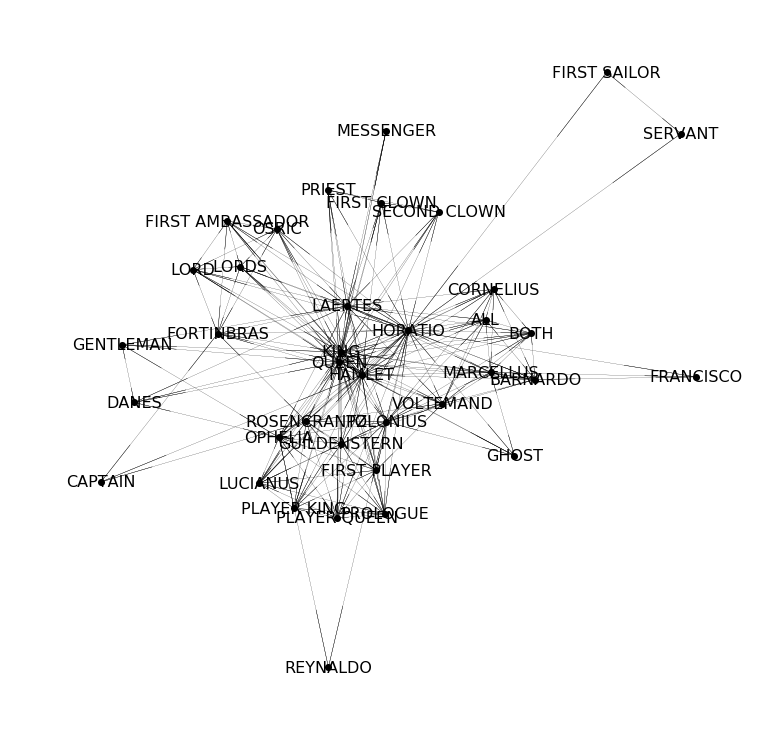

In [39]:
plt.figure(figsize=(10,10))

nx.draw(G,
    with_labels = True,
    node_color = 'black',
    node_size = 50,
    line_color = 'grey',
    linewidths = 0,
    width = 0.1,
    font_size = 16
    )

plt.show()

Let's look at some statistics.

In [40]:
betweeness_names = nx.betweenness_centrality(G, seed = 123)
betweeness_names

{'ALL': 0.0,
 'BARNARDO': 0.006957671957671959,
 'BOTH': 0.0,
 'CAPTAIN': 0.0,
 'CORNELIUS': 0.0,
 'DANES': 0.0,
 'FIRST AMBASSADOR': 0.0,
 'FIRST CLOWN': 0.0,
 'FIRST PLAYER': 0.0009700176366843035,
 'FIRST SAILOR': 0.0,
 'FORTINBRAS': 0.009947089947089947,
 'FRANCISCO': 0.0,
 'GENTLEMAN': 0.0,
 'GHOST': 0.0,
 'GUILDENSTERN': 0.0009700176366843035,
 'HAMLET': 0.10404257999496094,
 'HORATIO': 0.2148230032753842,
 'KING': 0.1097039556563366,
 'LAERTES': 0.062372134038800715,
 'LORD': 0.0,
 'LORDS': 0.0,
 'LUCIANUS': 0.0,
 'MARCELLUS': 0.009973544973544971,
 'MESSENGER': 0.0,
 'OPHELIA': 0.03665721844293273,
 'OSRIC': 0.0,
 'PLAYER KING': 0.0,
 'PLAYER QUEEN': 0.0,
 'POLONIUS': 0.051066389518770475,
 'PRIEST': 0.0,
 'PROLOGUE': 0.0,
 'QUEEN': 0.12409549004787103,
 'REYNALDO': 0.0,
 'ROSENCRANTZ': 0.016181657848324513,
 'SECOND CLOWN': 0.0,
 'SERVANT': 0.0,
 'VOLTEMAND': 0.004620181405895691}

In [41]:
#sort by value to find the most central character
sorted(betweeness_names, key=betweeness_names.get, reverse=True)

['HORATIO',
 'QUEEN',
 'KING',
 'HAMLET',
 'LAERTES',
 'POLONIUS',
 'OPHELIA',
 'ROSENCRANTZ',
 'MARCELLUS',
 'FORTINBRAS',
 'BARNARDO',
 'VOLTEMAND',
 'FIRST PLAYER',
 'GUILDENSTERN',
 'ALL',
 'CORNELIUS',
 'PLAYER KING',
 'SERVANT',
 'SECOND CLOWN',
 'CAPTAIN',
 'OSRIC',
 'PROLOGUE',
 'GHOST',
 'MESSENGER',
 'REYNALDO',
 'BOTH',
 'PLAYER QUEEN',
 'LUCIANUS',
 'PRIEST',
 'FIRST AMBASSADOR',
 'GENTLEMAN',
 'FIRST SAILOR',
 'FIRST CLOWN',
 'LORDS',
 'FRANCISCO',
 'DANES',
 'LORD']

Horatio is the most important go-between character for Hamlet. Does this surprise anyone?

In [42]:
eigenvector_names = nx.eigenvector_centrality(G)

#sort by value to find the most central character
sorted(eigenvector_names, key=eigenvector_names.get, reverse=True)

['QUEEN',
 'KING',
 'HORATIO',
 'HAMLET',
 'POLONIUS',
 'LAERTES',
 'OPHELIA',
 'ROSENCRANTZ',
 'VOLTEMAND',
 'FIRST PLAYER',
 'GUILDENSTERN',
 'PLAYER KING',
 'PROLOGUE',
 'PLAYER QUEEN',
 'LUCIANUS',
 'MARCELLUS',
 'BARNARDO',
 'ALL',
 'CORNELIUS',
 'BOTH',
 'FORTINBRAS',
 'OSRIC',
 'FIRST AMBASSADOR',
 'LORDS',
 'LORD',
 'SECOND CLOWN',
 'PRIEST',
 'FIRST CLOWN',
 'GHOST',
 'GENTLEMAN',
 'DANES',
 'MESSENGER',
 'FRANCISCO',
 'CAPTAIN',
 'REYNALDO',
 'SERVANT',
 'FIRST SAILOR']

Ah, a much different story!

### Final Thoughts

* Tom Stoppard is onto something, for sure. But what? What is this capturing? Don't deny the power of the little people? Peripheral characters might not be so peripheral? 

* Also, be careful with your centrality measures! Make sure you're measuring what you want to be measuring **(i.e., go take a class and learn the math behind this. You have just enough skills to be dangerous right now!).**

* How else might we measure a tie? If you want a challenge, repeat this exercise but measure ties differently. Do you get different graph statistics? 

* What else might we do with this?

### This is what structuring unstructured digitized data means. Questions? Reactions? What stands out to you from the exercise today?

When you're satisfied, change the last name on this file, save it, and upload it to Blackboard to get credit for your attendance today.